# Modelo de Jansen & Rit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

El modelo de Jansen & Rit está pensado para reproducir diversas características de las señales de EEG y MEG. El modelo parte del trabajo de Lopes da Silva et al. (1974), y luego fue extendido en un primera instancia en un artículo de Rit et al. (1993). El modelo toma su nombre del artículo de Jansen & Rit (1995), donde simulan la interacción de dos regiones cerebrales como columnas corticales acopladas.

Cada nodo del modelo constitye una columna cortical. Esta consiste en una población de neuronas piramidales --ubicadas principalmente en la capa 5 de la columna cortical-- que reciben una retroalimentación excitatoria e inhibitoria de interneuronas locales dentro de la misma columna, estímulos excitatorios de columnas vecinas o regiones subcorticales, representados a través de una variable de input $p(t)$. Las interneuronas excitatorias representan otras neuronas piramidales de la misma capa 5, que proyectan localmente. Las interneuronas inhibitorias también proyectan localmente. El modelo se presenta de forma esquemática en la **Figura 1.**



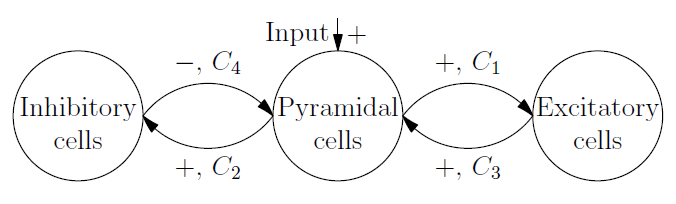

**Figura 1. Esquema del modelo de Jansen & Rit.** Una población de neuronas piramidales se comunica con dos poblaciones de interneuronas: excitatorias e inhibitorias. Estás proyectan nuevamente a la población de neuronas piramidales. Las poblaciones están conectadas por una serie de constantes $C_1$, $C_2$, $C_3$, y $C_4.$. Las neuronas piramidales además reciben estímulos externos excitatorios (*Input* en la figura).

Cada columna está modelada por dos bloques. El primero transforma el firing rate promedio proveniente de los potenciales de acción de entrada, en potencial de membrana promedio (el cual puede ser excitatorio o inhibitorio), medido en voltaje. Este bloque, denominado bloque de potencial postsináptico (PSP), está dado por una función de respuesta a impulso (*impulse response function*)

$$ h_{E,S}(t) = \begin{cases} Aate^{-at}, & t\geq0 \\ 0, &t<0 \end{cases} $$

para las salidas excitatorias, y

$$ h_{I,S}(t) = \begin{cases} Bbte^{-bt}, & t\geq0 \\ 0, &t<0 \end{cases}$$

para las salidas inhibitorias. Los constantes $A$ y $B$ determinan la máxima amplitud de los PSPs excitatorios (EPSPs) e inhibitorios (IPSPs), mientras que las constantes $a$ y $b$ representan el recíproco de la suma de las constantes de tiempo de membrana y los retrasos a través del árbol dendrítico para los casos excitatorios e inhibitorios. Para este primer bloque, Jansen & Rit escogen los siguientes valores para los parámetros: $A = 3.25$ mV, $B = 22$ mV, $a = 100$ s$^{-1}$, $b = 50$ s$^{-1}$. Estos valores dan como resultados IPSPs de mayor amplitud y latencia en comparación con los EPSPs, tal como se reporta experimentalmente. 



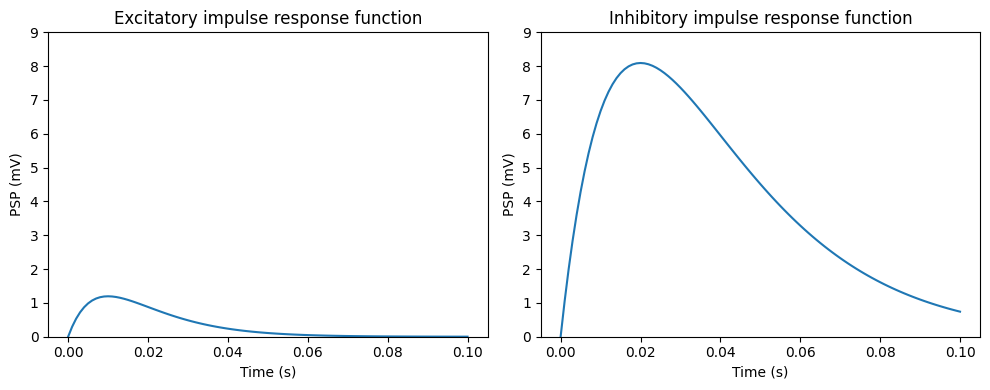

In [2]:
#Funciones de respuesta a impulso
t = np.linspace(0,0.1,101) #Vector de tiempo en segundos
a, b = 100, 50 #Constantes características (s^-1)
A, B = 3.25, 22 #Amplitud máxima de los EPSPs e IPSPs, respectivamente

hE = A * a * t * np.exp(-a * t) #Función de respuesta a impulso (excitatoria)
hI = B * b * t * np.exp(-b * t) #Función de respuesta a impulso (inhibitoria)

plt.figure(1,figsize=(10,4))
plt.clf()
plt.subplot(1,2,1)
plt.plot(t,hE)
plt.xlabel('Time (s)')
plt.ylabel('PSP (mV)')
plt.title(r'Excitatory impulse response function')
plt.ylim(0,9)
plt.subplot(1,2,2)
plt.plot(t,hI)
plt.xlabel('Time (s)')
plt.ylabel('PSP (mV)')
plt.title(r'Inhibitory impulse response function')
plt.ylim(0,9)
plt.tight_layout()



El segundo bloque transforma el potencial de membrana promedio de la población de neuronas en firing rate promedio. Esta transformación se describe como una función sigmoide de la forma

\begin{equation}
S(v) = \frac{e_0}{1 + e^{r(v_0 - v)}}
\end{equation}

donde $e_0$ determina la máxima tasa de disparo de la población neuronal, $r$ la pendiente de la función sigmoide, y $v_0$ el valor del potencial de membrana en el cual se alcanza el 50\% del valor de $e_0$. Los valores por defecto del modelo corresponden a: $e_0 = 5$ Hz, $v_0 = 6$ mV, $r= 0.56$ mV$^{-1}$. La función sigmoide se muestra en el próximo bloque.

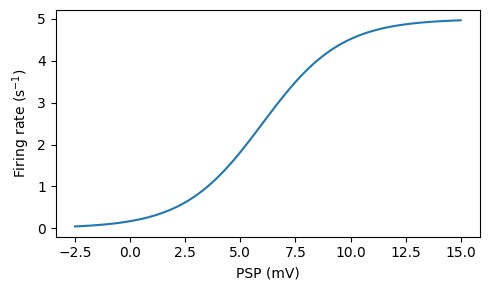

In [3]:
#Función sigmoide
v = np.linspace(-2.5,15,101) #PSP en mV
r = 0.56 #Pendiente de la función sigmoide en mV^-1
v0 = 6 #V1/2 de la función en mV
e0 = 5 #maxima tasa de disparo en s^-1

def S(v):
    return(e0 / (1 + np.exp(r*(v0 - v))))

plt.figure(2, figsize = (5,3))
plt.clf()
plt.plot(v,S(v))
plt.xlabel('PSP (mV)')
plt.ylabel(r'Firing rate (s$^{-1}$)')
plt.tight_layout()


Luego, vamos a denotar como $x(t)$ a la salida de uno de los bloques PSP. Esta salida puede representarse como una convolución entre la suma de los estímulos de entrada $z(t)$ y la función de respuesta a impulso

\begin{align}
x(t) &:= z(t) \circledast h(t) \\
x(t) &:= \int_{0}^{t}z(\tau)\alpha\beta(t-\tau)\exp(-\beta(t-\tau)) d\tau
\end{align}

donde $(\alpha,\beta) = (A,a)$ para los EPSPs, y $(\alpha,\beta) = (B,b)$ para los IPSPs.





De forma análoga a un sistema masa resorte, el término $\dot{x}$ corresponde a la "velocidad" de cambio de las salidas de los bloques PSP, mientras que el término $\dot{y}$ a la acelaración. El término $z(t)$ corresponde a las entradas (los estímulos) que entran a cada bloque PSP. Estas entradas pueden apreciarse en el esquema de la **Figura 2**.

**Nota:** los términos $x_i$ no representan a cada una de las poblaciones de neuronas en el modelo, sino a las salidas de cada bloque PSP.


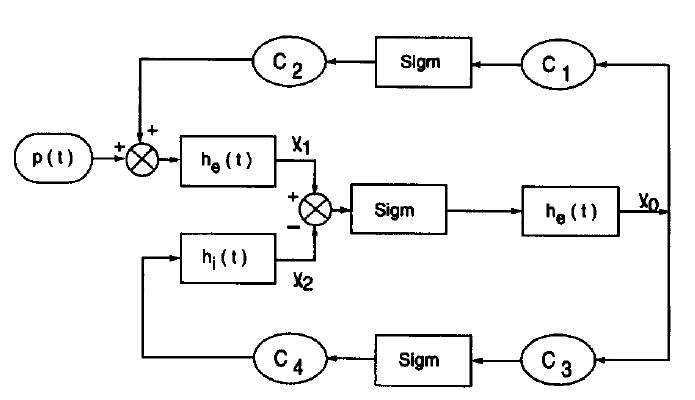

**Figura 2. Bloques del modelo de Jansen & Rit.** Dos bloques realizan las transformaciones en el modelo. Un bloque, denominado bloque PSP y denotado por las cajas $h_e(t)$ (para los EPSPs) y $h_i(t)$ (para los IPSPs), transforma los *firing rates* en potencial de membrana promedio. Luego, una función sigmoide $S$ revierte este cambio. Los círculos con cuadrículas representan puntos donde se integran más de dos estímulos (excitatorios denotados por un $+$ e inhibitorios denotados por un $-$).

En el modelo se incluyen los siguientes términos:

- $x_0$ corresponde a la salida del bloque PSP de las neuronas piramidales.
- $x_1$ corresponde al total de entradas excitatorias que reciben las neuronas piramidales.
- $x_2$ corresponde al total de entradas inhibitorias que reciben estas mismas neuronas.


Entonces, de la figura dos se puede concluir que las entradas $z(t)$ que recibe cada uno de los bloques corresponden a:

- Bloque 0 (neuronas piramidales): $S(C_2x_1 - C_4x_2)$, donde $x_1$ y $x_2$ corresponden al total de entradas excitatorias e inhibitorias, respectivamente, escaladas por sus respectivas constantes de conectividad $C_2$ y $C_4$. Nótase que el signo negativo asociado a $x_2$ señala la naturaleza de la conexión (inhibitoria).
- Bloque 1 (feedback excitatorio): $S(C_1x_0)$, donde $x_0$ es la salidad del bloque PSP de las neuronas piramidales escalada por $C_1$.
- Bloque 2 (feedback inhibitorio): $S(C_3x_0)$, donde $x_0$ es la salidad del bloque PSP de las neuronas piramidales escalada por $C_3$.

Así, el sistema de ecuaciones puede reescribirse como un sistema de 6 ecuaciones diferenciales de primer orden

$$\begin{align}
\begin{split}
\dot{x_{0}}(t) = & y_{0}(t) \\
\dot{y_{0}}(t) = & Aa\left[S(x_{1}(t) - x_{2}(t))\right] - 2ay_{0}(t) - a^{2}x_{0}(t) \\
\dot{x_{1}}(t) = & y_{1}(t) \\
\dot{y_{1}}(t) = & Aa \left[p(t) + C_2S(C_1x_{0}(t))\right] - 2ay_{1}(t) - a^{2}x_{0}(t) \\
\dot{x_{2}}(t) = & y_{2}(t) \\
\dot{y_{2}}(t) = & Bb \left[C_4S(C_3y_{0}(t)) \right] - 2by_{2}(t) - b^{2}x_{2}(t)
\end{split}
\end{align}$$

Los valores de las constantes se escogen como $C_1 = C$, $C_2 = 0.8C$, $C_3 = 0.25C$, $C_4 = 0.25C$, con $C=135$. El estímulo externo, $p(t)$ puede ser constante o tomado de alguna distribución aleatoria. En los siguientes ejemplos se tomará de una distribución uniforme.

En el modelo de Jansen & Rit la señal de M/EEG está represantada por el PSP de las neuronas piramidales. Este se puede definir como

\begin{equation}
V(t) = x_1(t) - x_2(t)
\end{equation}

es decir, se define como la diferencia entre lo que entra a las neuronas piramidales como excitación e inhibición. Paso siguiente, vamos a programar el modelo de Jansen & Rit.

## Modelo de Jansen & Rit en Python

In [4]:
#Modelo de Jansen & Rit
def JansenRit(y,t):
    x0,x1,x2,y0,y1,y2 = y #Entradas del modelo, t representa el tiempo

    #Estímulo externo tomado de una distribución uniforme
    p = np.random.uniform(150,550)

    #Salida del Bloque 0 (piramidales)
    x0_dot = y0
    y0_dot = A * a * S(x1 - x2) - 2 * a * y0 - a**2 * x0
    #Salida del Bloque 1 (interneuronas excitatorias)
    x1_dot = y1
    y1_dot = A * a * (p + C2 * S(C1 * x0)) - 2 * a * y1 - a**2 * x1
    #Salida del Bloque 2 (interneuronas inhibitorias)
    x2_dot = y2
    y2_dot = B * b * (C4 * S(C3 * x0)) - 2 * b * y2 - b**2 * x2

    return(np.array([x0_dot,x1_dot,x2_dot,y0_dot,y1_dot,y2_dot]))


In [18]:
#Simular una señal de EEG

#Parámetros de simulación
dt = 1E-3 #Paso de integración (en segundos)
tmax = 60 #Tiempo de simulación (en segundos)
N = int(tmax/dt) #Total de puntos de simulación
t = np.linspace(0,tmax,N) #Vector de tiempo
seed = 0 #Semilla aleatoria

#Parámetros del modelo
A, B = 3.25,22#3.25, 22 #Amplitud de los EPSPs e IPSPs
a, b = 100, 50 #Constantes de tiempo características
C = 135 #Acoplamiento global intra-columna
C1, C2, C3, C4 = C, 0.8 * C, 0.25 * C, 0.25 * C #Constantes de conectividad

#Función sigmoide
r = 1#0.56 #Pendiente de la función sigmoide en mV^-1
v0 = 6 #V1/2 de la función en mV
e0 = 5 #maxima tasa de disparo en s^-1

#Función sigmoide
def S(v):
    return(e0 / (1 + np.exp(r*(v0 - v))))

#Condiciones iniciales y matriz para guardar resultados
ic = np.array([0.1,0.1,0.1,0.1,0.1,0.1])
results = np.zeros((N,6))
results[0,:] = ic

#Fijar la semilla aleatoria
np.random.seed(seed)
#Resolución del sistema de ecuaciones con el método de Euler
for i in range(1,N):
    results[i,:] = results[i-1,:] + JansenRit(results[i-1,:],i) * dt

#Esta señal constituye la salida del modelo de Jansen & Rit, y corresponde a una señal tipo EEG
EEG = results[:,1] - results[:,2]


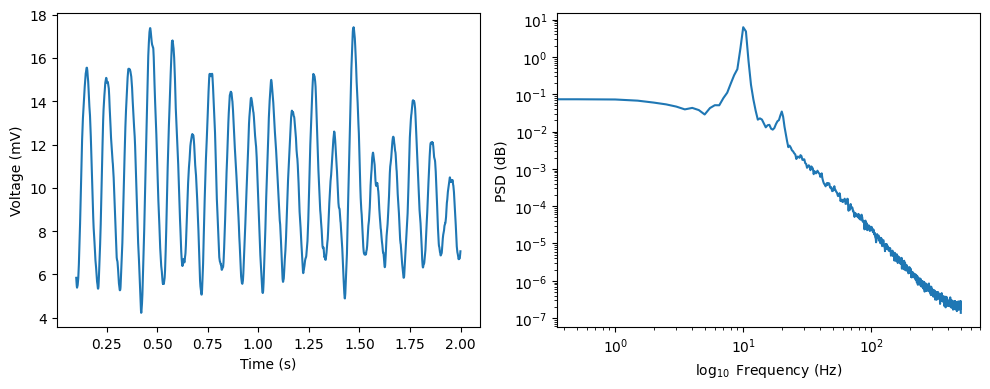

In [19]:
#Plots: señal de EEG y espectro de potencia (con el método de Welch)
#El método de Welch permite obtener espectros menos ruidosos, en comparación a usar la transformada de Fourier

window_length = 2 #en segundos
PSD_window = int(window_length / dt) #vetana en número de puntos
#PSD: power spectral density
PSD = signal.welch(EEG, fs = 1 / dt,
                    nperseg = PSD_window, noverlap = PSD_window // 2,
                    scaling = 'density')
freq_vector = PSD[0] #Vector de frecuencias
PSD_curves =  PSD[1] #Power spectral density

plt.figure(figsize=(10,4))
plt.clf()
plt.subplot(1,2,1)
plt.plot(t[100:2000],EEG[100:2000])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.subplot(1,2,2)
plt.loglog(freq_vector,PSD_curves)
plt.xlabel(r'$\log_{10}$ Frequency (Hz)')
plt.ylabel(r'PSD (dB)') #db: decibeles
plt.tight_layout()



## Comparación con registros de EEG

En los registros de M/EEG en resting-state, en personas sanas, las señales tienen una forma de *waxing and waining ouput*, que corresponde a oscilaciones que aumentan y decrecen en amplitud, con un *peak* en el espectro de potencias alrededor de los 10 Hz. Este tipo de señales se muestran en la **Figura 3**, tomada de Jansen & Rit (1995).

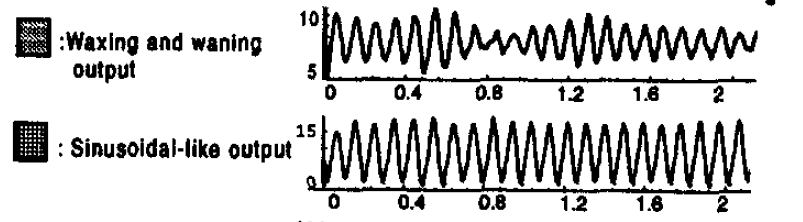

**Figura 3. Señales tipo EEG** Las señales tipo *waxing and waining ouput* son características de los registros de EEG en resting-state. Tomada de Jansen & Rit (1995).

Los diversos parámetros del modelo pueden usarse para producir distintos patrones de actividad, propios de los registros de M/EEG: actividad cerebral en las diferentes etapas del sueño, o durante ataques epilépticos, registros de resting-state, entre otros.

El modelo de Jansen & Rit puede usarse además para construir modelos de cerebro completo, permitiendo así reproducir la activididad cerebral, en forma de señales de M/EEG, en un gran número de condiciones en el cerebro sano y en patologías neuropsiquiátricas.

## Paper original de Jansen & Rit (1995). https://doi.org/10.1007/BF00199471



## Actividades Extra

**1)** Una disminución del tono inhibitorio mediado por las interneuronas inhibitorias puede producir un aumento del ratio excitatión/inhibición (E/I) en las neuronas piramidales, generando señales de EEG de alta amplitud, que caen en el rango $\theta$ del espectro del EEG (entre 4 y 8 Hz). ¿Para qué valores del parámetro $b$ del modelo de Jansen & Rit se observan este tipo de señales? Ver registro asociado a pacientes con Alzheimer tomado de Stefanovski et. al. (2019), donde las oscilaciones en el rango $\theta$ son evidendetemente apreciables. Se hipotetiza que la aparición de estas oscilaciones en los pacientes con Alzheimer se debe a un desbalance en el ratio E/I (Stefanovski et. al., 2019).

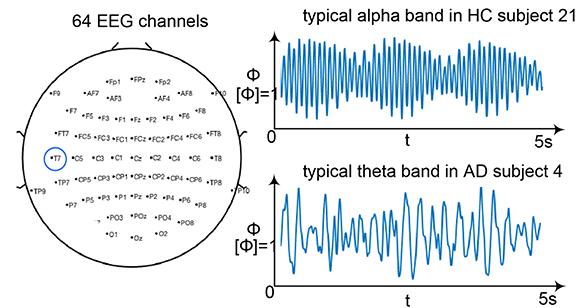

**Figura 4. Señales de EEG simuladas en Alzheimer**. La figura superior corresponde a un registro de EEG de una persona sana, mientras que la inferior al de un paciente con Alzheimer. En el primer caso las oscilaciones caen en el rango $\alpha$ (8-13 Hz) del espectro del EEG, y en el segundo en el rango $\theta$ (4-8 Hz). Tomada de Stefanovski et al. (2019).

**2)** La epilepsia se caracteriza por la aparición, en los registros de EEG, de oscilaciones de alta amplitud a manera de *spikes*; a su vez, las señales de EEG tienden a sobre-sincronizarse respecto a condiciones saludables. Si bien la epilepsia constituye una forma de sobre-excitación del sistema (un aumento del ratio E/I), también puede producirse por un incremento de la actividad inhibitoria (Wendling et al., 2002). Modifique el modelo de Jansen & Rit para añadir un input adicional a la población de interneuronas inhibitorias (puede ser un input constante o aleatorio). Intente reproducir la **Figura 5** tomada de Spiegler et al. (2010), donde un incremento del input a las interneuronas inhibitorias produce una transición desde oscilaciones en el rango $\alpha$ del espectro del EEG, hasta la producción de un ataque epiléptico, para finalizar con oscilaciones de baja amplitud cuando el input llega a valores muy altos.


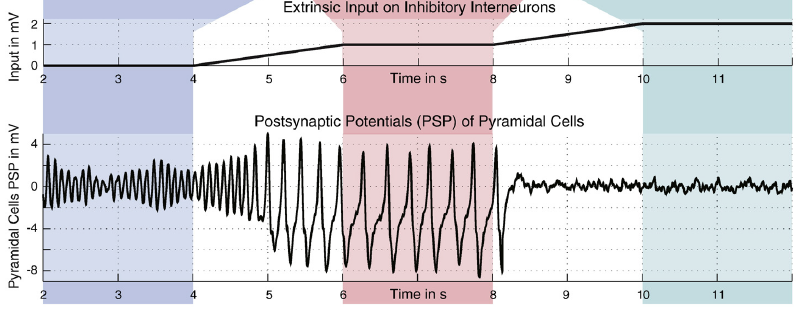

**Figura 5. Efecto de añadir un input externo excitatorio a las interneuronas inhibitorias**. El input se va incrementando de izquierda a derecha en la figura superior. El EEG pasa, a valores del input bajos, desde señales en el rango $\alpha$ hasta señales propias de ataques epilépticos (al incrementar el input), finalizando en oscilaciones de baja amplitud a valores del input elevados. Tomada parcialmente de Spiegler et al. (2010).

**Nota:** No tiene que ser una reproducción exacta de la figura. Basta con conseguir tres regímenes de actividad, que dependan del input aplicado a las interneuronas inhibitorias, similares a los de la **Figura 5**.


### Referencias

Jansen, B. H., & Rit, V. G. (1995). Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns. Biological cybernetics, 73(4), 357-366.

Spiegler, A., Kiebel, S. J., Atay, F. M., & Knösche, T. R. (2010). Bifurcation analysis of neural mass models: Impact of extrinsic inputs and dendritic time constants. NeuroImage, 52(3), 1041-1058.

Stefanovski, L., Triebkorn, J. P., Spiegler, A., Diaz-Cortes, M. A., Solodkin, A., Jirsa, V., ... & Ritter, P. (2019). Linking molecular pathways and large-scale computational modeling to assess candidate disease mechanisms and pharmacodynamics in Alzheimer’s disease. Frontiers in computational neuroscience, 13, 54.
